In [1]:
import os
import tempfile
import shutil
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

from medmnist import ChestMNIST
from pytorch_fid import fid_score
from skimage.metrics import structural_similarity as ssim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

latent_dim = 100
embedding_dim = 10
num_classes = 2  # 0: non-pneumonia, 1: pneumonia
img_size = 64
img_channels = 1  # Grayscale images
batch_size = 64
num_epochs = 400    # Maximum number of epochs; you can extend this as needed
lr = 0.0004
step_size = 25     # Every 50 epochs, the LR will be decayed
gamma = 0.99        # Decay factor for LR

Using device: cuda


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.block(x)
        out += x  # Skip connection
        return self.relu(out)


In [4]:
class GeneratorVanilla(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size):
        super(GeneratorVanilla, self).__init__()
        self.init_size = img_size // 4
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_size * self.init_size)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(
            ResidualBlock(256)
        )

        self.final_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        out = self.fc(noise)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        out = self.conv_blocks(out)
        out = self.residual_blocks(out)
        img = self.final_blocks(out)
        return img


In [6]:
class DiscriminatorVanilla(nn.Module):
    def __init__(self, img_channels, img_size):
        super(DiscriminatorVanilla, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        ds_size = img_size // 2**4
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity


In [7]:
generator = GeneratorVanilla(latent_dim, img_channels, img_size).to(device)
discriminator = DiscriminatorVanilla(img_channels, img_size).to(device)

print(generator)
print(discriminator)

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=step_size, gamma=gamma)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=step_size, gamma=gamma)

GeneratorVanilla(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
  )
  (final_

In [8]:
from torchvision.transforms.functional import hflip, to_tensor
from torch.utils.data import Dataset, ConcatDataset
import torch
from medmnist import ChestMNIST

class PneumoniaDataset(Dataset):
    def __init__(self, base_dataset, label_index=6, flip=False):
        self.base_dataset = base_dataset
        self.label_index = label_index
        self.flip = flip
        self.indices = [i for i in range(len(base_dataset)) if int(base_dataset[i][1][label_index]) == 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, _ = self.base_dataset[real_idx]  # img is PIL.Image

        img = to_tensor(img)  # Now it's a tensor in [0, 1], shape (1, 64, 64)

        if self.flip:
            img = hflip(img)

        img = img * 2 - 1  # Normalize to [-1, 1]
        return img, 1  # dummy label

    
full_dataset = ChestMNIST(split='train', transform=None, download=True,size=64)
pneumonia_original = PneumoniaDataset(full_dataset, flip=False)
pneumonia_flipped = PneumoniaDataset(full_dataset, flip=True)

augmented_dataset = ConcatDataset([pneumonia_original, pneumonia_flipped])
pneumonia_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)


In [9]:
def sample_real_images(loader, num_samples=100):
    imgs_list = []
    count = 0
    for imgs, _ in loader:
        imgs_list.append(imgs)
        count += imgs.size(0)
        if count >= num_samples:
            break
    imgs = torch.cat(imgs_list, dim=0)[:num_samples]
    imgs = (imgs + 1) / 2  # Convert from [-1,1] to [0,1]
    return imgs

fixed_real = sample_real_images(pneumonia_loader, num_samples=100)

In [10]:
def save_images_to_folder(images, folder, prefix):
    os.makedirs(folder, exist_ok=True)
    for i in range(images.size(0)):
        img = images[i]
        save_path = os.path.join(folder, f"{prefix}_{i}.png")
        utils.save_image(img, save_path)

def compute_batch_ssim(real_imgs, fake_imgs):
    # Assume real_imgs and fake_imgs are numpy arrays of shape (N, 1, H, W)
    real_imgs = real_imgs.squeeze(1)
    fake_imgs = fake_imgs.squeeze(1)
    ssim_vals = []
    for i in range(real_imgs.shape[0]):
        s = ssim(real_imgs[i], fake_imgs[i], data_range=1.0)
        ssim_vals.append(s)
    return np.mean(ssim_vals)

In [11]:
temp_real_dir = tempfile.mkdtemp()
temp_fake_dir = tempfile.mkdtemp()

In [12]:
best_fid = float('inf')
best_epoch = 0

print("Starting Vanilla GAN training with Learning Rate Scheduler...")
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    for i, (imgs, _) in enumerate(pneumonia_loader):
        current_batch = imgs.size(0)
        valid = torch.ones(current_batch, 1, device=device)
        fake_label = torch.zeros(current_batch, 1, device=device)

        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(current_batch, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake_label)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(pneumonia_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    scheduler_G.step()
    scheduler_D.step()

    # ---------------------
    #  Evaluate and Save
    # ---------------------
    generator.eval()
    with torch.no_grad():
        z = torch.randn(100, latent_dim, device=device)
        gen_imgs = generator(z)

    gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0,1]

    # Clear temp directories
    for f in os.listdir(temp_real_dir):
        os.remove(os.path.join(temp_real_dir, f))
    for f in os.listdir(temp_fake_dir):
        os.remove(os.path.join(temp_fake_dir, f))
    save_images_to_folder(fixed_real, temp_real_dir, "real")
    save_images_to_folder(gen_imgs, temp_fake_dir, "fake")

    current_fid = fid_score.calculate_fid_given_paths(
        [temp_real_dir, temp_fake_dir],
        batch_size, device, dims=2048
    )
    fixed_real_np = fixed_real.cpu().numpy()
    fake_imgs_np = gen_imgs.cpu().numpy()
    current_ssim = compute_batch_ssim(fixed_real_np, fake_imgs_np)

    print(f"Epoch {epoch} -- FID: {current_fid:.3f}, SSIM: {current_ssim:.3f}")

    if current_fid < best_fid:
        best_fid = current_fid
        best_epoch = epoch
        torch.save(generator.state_dict(), "best_vanilla_generator.pth")
        print(f"New best model found at epoch {epoch} with FID: {current_fid:.3f}")

print(f"Training complete. Best FID: {best_fid:.3f} at epoch {best_epoch}.")


100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 197 -- FID: 137.919, SSIM: 0.310
[Epoch 198/400] [Batch 0/31] [D loss: 0.3035] [G loss: 1.3872]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 198 -- FID: 137.046, SSIM: 0.310
[Epoch 199/400] [Batch 0/31] [D loss: 0.4506] [G loss: 1.6782]


100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch 199 -- FID: 157.642, SSIM: 0.305
[Epoch 200/400] [Batch 0/31] [D loss: 0.3269] [G loss: 1.4724]


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch 200 -- FID: 146.513, SSIM: 0.334
[Epoch 201/400] [Batch 0/31] [D loss: 0.4506] [G loss: 1.3328]


100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch 201 -- FID: 151.084, SSIM: 0.332
[Epoch 202/400] [Batch 0/31] [D loss: 0.5261] [G loss: 1.3368]


100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


Epoch 202 -- FID: 142.870, SSIM: 0.335
[Epoch 203/400] [Batch 0/31] [D loss: 0.3513] [G loss: 1.6481]


100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch 203 -- FID: 149.518, SSIM: 0.320
[Epoch 204/400] [Batch 0/31] [D loss: 0.4395] [G loss: 1.3075]


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch 204 -- FID: 133.846, SSIM: 0.329
[Epoch 205/400] [Batch 0/31] [D loss: 0.4699] [G loss: 1.3853]


100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


Epoch 205 -- FID: 136.314, SSIM: 0.330
[Epoch 206/400] [Batch 0/31] [D loss: 0.3360] [G loss: 2.2337]


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch 206 -- FID: 128.201, SSIM: 0.325
New best model found at epoch 206 with FID: 128.201
[Epoch 207/400] [Batch 0/31] [D loss: 0.6727] [G loss: 2.8158]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 207 -- FID: 141.868, SSIM: 0.315
[Epoch 208/400] [Batch 0/31] [D loss: 0.4886] [G loss: 1.4193]


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 208 -- FID: 143.393, SSIM: 0.321
[Epoch 209/400] [Batch 0/31] [D loss: 0.4584] [G loss: 1.4034]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 209 -- FID: 138.534, SSIM: 0.296
[Epoch 210/400] [Batch 0/31] [D loss: 0.4484] [G loss: 1.5695]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 210 -- FID: 155.407, SSIM: 0.322
[Epoch 211/400] [Batch 0/31] [D loss: 0.3434] [G loss: 1.2595]


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Epoch 211 -- FID: 138.080, SSIM: 0.311
[Epoch 212/400] [Batch 0/31] [D loss: 0.4210] [G loss: 2.0529]


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 212 -- FID: 135.882, SSIM: 0.318
[Epoch 213/400] [Batch 0/31] [D loss: 0.4500] [G loss: 1.8231]


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Epoch 213 -- FID: 139.658, SSIM: 0.300
[Epoch 214/400] [Batch 0/31] [D loss: 0.5111] [G loss: 1.7576]


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


Epoch 214 -- FID: 137.425, SSIM: 0.308
[Epoch 215/400] [Batch 0/31] [D loss: 0.4060] [G loss: 2.1171]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 215 -- FID: 143.800, SSIM: 0.312
[Epoch 216/400] [Batch 0/31] [D loss: 0.4598] [G loss: 1.3710]


100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


Epoch 216 -- FID: 143.233, SSIM: 0.329
[Epoch 217/400] [Batch 0/31] [D loss: 0.4931] [G loss: 1.5327]


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


Epoch 217 -- FID: 147.342, SSIM: 0.308
[Epoch 218/400] [Batch 0/31] [D loss: 0.4510] [G loss: 1.5809]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 218 -- FID: 139.395, SSIM: 0.325
[Epoch 219/400] [Batch 0/31] [D loss: 0.4077] [G loss: 2.4241]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 219 -- FID: 142.109, SSIM: 0.308
[Epoch 220/400] [Batch 0/31] [D loss: 0.5870] [G loss: 2.3911]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 220 -- FID: 138.391, SSIM: 0.340
[Epoch 221/400] [Batch 0/31] [D loss: 0.4450] [G loss: 1.4466]


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


Epoch 221 -- FID: 142.218, SSIM: 0.315
[Epoch 222/400] [Batch 0/31] [D loss: 0.3348] [G loss: 1.5278]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 222 -- FID: 145.171, SSIM: 0.324
[Epoch 223/400] [Batch 0/31] [D loss: 0.3434] [G loss: 1.5166]


100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 223 -- FID: 135.297, SSIM: 0.323
[Epoch 224/400] [Batch 0/31] [D loss: 0.4633] [G loss: 1.7220]


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Epoch 224 -- FID: 144.016, SSIM: 0.321
[Epoch 225/400] [Batch 0/31] [D loss: 0.3865] [G loss: 1.7317]


100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 225 -- FID: 147.077, SSIM: 0.308
[Epoch 226/400] [Batch 0/31] [D loss: 0.4445] [G loss: 2.0347]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 226 -- FID: 134.912, SSIM: 0.309
[Epoch 227/400] [Batch 0/31] [D loss: 0.4418] [G loss: 2.2589]


100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


Epoch 227 -- FID: 148.154, SSIM: 0.318
[Epoch 228/400] [Batch 0/31] [D loss: 0.4416] [G loss: 1.8943]


100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


Epoch 228 -- FID: 137.261, SSIM: 0.323
[Epoch 229/400] [Batch 0/31] [D loss: 0.3656] [G loss: 1.6763]


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


Epoch 229 -- FID: 147.976, SSIM: 0.319
[Epoch 230/400] [Batch 0/31] [D loss: 0.4333] [G loss: 1.1838]


100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


Epoch 230 -- FID: 151.687, SSIM: 0.324
[Epoch 231/400] [Batch 0/31] [D loss: 0.3808] [G loss: 1.6141]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 231 -- FID: 131.078, SSIM: 0.318
[Epoch 232/400] [Batch 0/31] [D loss: 0.4737] [G loss: 1.2714]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 232 -- FID: 143.143, SSIM: 0.333
[Epoch 233/400] [Batch 0/31] [D loss: 0.4264] [G loss: 2.0752]


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Epoch 233 -- FID: 134.269, SSIM: 0.334
[Epoch 234/400] [Batch 0/31] [D loss: 0.3202] [G loss: 1.9713]


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch 234 -- FID: 150.234, SSIM: 0.322
[Epoch 235/400] [Batch 0/31] [D loss: 0.5626] [G loss: 1.3207]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 235 -- FID: 152.732, SSIM: 0.326
[Epoch 236/400] [Batch 0/31] [D loss: 0.4049] [G loss: 1.3636]


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 236 -- FID: 158.402, SSIM: 0.326
[Epoch 237/400] [Batch 0/31] [D loss: 0.4335] [G loss: 1.4488]


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


Epoch 237 -- FID: 148.874, SSIM: 0.317
[Epoch 238/400] [Batch 0/31] [D loss: 0.4098] [G loss: 1.9986]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 238 -- FID: 142.212, SSIM: 0.317
[Epoch 239/400] [Batch 0/31] [D loss: 0.4501] [G loss: 1.9757]


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


Epoch 239 -- FID: 140.688, SSIM: 0.314
[Epoch 240/400] [Batch 0/31] [D loss: 0.3975] [G loss: 1.2117]


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Epoch 240 -- FID: 153.471, SSIM: 0.312
[Epoch 241/400] [Batch 0/31] [D loss: 0.5178] [G loss: 1.7989]


100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 241 -- FID: 136.051, SSIM: 0.310
[Epoch 242/400] [Batch 0/31] [D loss: 0.3543] [G loss: 1.9833]


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


Epoch 242 -- FID: 134.075, SSIM: 0.325
[Epoch 243/400] [Batch 0/31] [D loss: 0.4873] [G loss: 1.2189]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 243 -- FID: 141.626, SSIM: 0.302
[Epoch 244/400] [Batch 0/31] [D loss: 0.4835] [G loss: 1.8688]


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


Epoch 244 -- FID: 156.004, SSIM: 0.314
[Epoch 245/400] [Batch 0/31] [D loss: 0.4844] [G loss: 0.8838]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 245 -- FID: 128.130, SSIM: 0.321
New best model found at epoch 245 with FID: 128.130
[Epoch 246/400] [Batch 0/31] [D loss: 0.3518] [G loss: 1.8840]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 246 -- FID: 137.476, SSIM: 0.331
[Epoch 247/400] [Batch 0/31] [D loss: 0.3695] [G loss: 2.0066]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 247 -- FID: 137.752, SSIM: 0.317
[Epoch 248/400] [Batch 0/31] [D loss: 0.3480] [G loss: 2.1607]


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Epoch 248 -- FID: 142.180, SSIM: 0.320
[Epoch 249/400] [Batch 0/31] [D loss: 0.3887] [G loss: 1.1258]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 249 -- FID: 139.883, SSIM: 0.326
[Epoch 250/400] [Batch 0/31] [D loss: 0.3590] [G loss: 1.7945]


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


Epoch 250 -- FID: 133.628, SSIM: 0.313
[Epoch 251/400] [Batch 0/31] [D loss: 0.3871] [G loss: 1.5579]


100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch 251 -- FID: 141.141, SSIM: 0.333
[Epoch 252/400] [Batch 0/31] [D loss: 0.4244] [G loss: 1.6873]


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 252 -- FID: 142.500, SSIM: 0.320
[Epoch 253/400] [Batch 0/31] [D loss: 0.3807] [G loss: 1.8284]


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Epoch 253 -- FID: 152.484, SSIM: 0.333
[Epoch 254/400] [Batch 0/31] [D loss: 0.4721] [G loss: 2.3813]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 254 -- FID: 138.643, SSIM: 0.318
[Epoch 255/400] [Batch 0/31] [D loss: 0.4409] [G loss: 1.6718]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 255 -- FID: 146.504, SSIM: 0.334
[Epoch 256/400] [Batch 0/31] [D loss: 0.4076] [G loss: 1.5877]


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Epoch 256 -- FID: 131.003, SSIM: 0.326
[Epoch 257/400] [Batch 0/31] [D loss: 0.3155] [G loss: 2.0896]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 257 -- FID: 147.780, SSIM: 0.311
[Epoch 258/400] [Batch 0/31] [D loss: 0.2945] [G loss: 2.3096]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 258 -- FID: 132.876, SSIM: 0.308
[Epoch 259/400] [Batch 0/31] [D loss: 0.2697] [G loss: 1.9199]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 259 -- FID: 137.315, SSIM: 0.324
[Epoch 260/400] [Batch 0/31] [D loss: 0.3506] [G loss: 2.0912]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 260 -- FID: 141.034, SSIM: 0.303
[Epoch 261/400] [Batch 0/31] [D loss: 0.2931] [G loss: 1.8707]


100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


Epoch 261 -- FID: 146.228, SSIM: 0.329
[Epoch 262/400] [Batch 0/31] [D loss: 0.3306] [G loss: 1.7951]


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


Epoch 262 -- FID: 140.649, SSIM: 0.333
[Epoch 263/400] [Batch 0/31] [D loss: 0.4355] [G loss: 2.0858]


100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch 263 -- FID: 140.783, SSIM: 0.318
[Epoch 264/400] [Batch 0/31] [D loss: 0.3240] [G loss: 1.8966]


100%|██████████| 2/2 [00:08<00:00,  4.00s/it]


Epoch 264 -- FID: 154.884, SSIM: 0.324
[Epoch 265/400] [Batch 0/31] [D loss: 0.4585] [G loss: 1.8798]


100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 265 -- FID: 154.507, SSIM: 0.329
[Epoch 266/400] [Batch 0/31] [D loss: 0.2875] [G loss: 1.6883]


100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


Epoch 266 -- FID: 124.817, SSIM: 0.330
New best model found at epoch 266 with FID: 124.817
[Epoch 267/400] [Batch 0/31] [D loss: 0.3135] [G loss: 2.1807]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 267 -- FID: 145.244, SSIM: 0.311
[Epoch 268/400] [Batch 0/31] [D loss: 0.2771] [G loss: 2.1197]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 268 -- FID: 144.686, SSIM: 0.321
[Epoch 269/400] [Batch 0/31] [D loss: 0.3907] [G loss: 1.5014]


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 269 -- FID: 136.468, SSIM: 0.333
[Epoch 270/400] [Batch 0/31] [D loss: 0.3481] [G loss: 1.8626]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 270 -- FID: 147.607, SSIM: 0.308
[Epoch 271/400] [Batch 0/31] [D loss: 0.4814] [G loss: 1.9226]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 271 -- FID: 143.727, SSIM: 0.308
[Epoch 272/400] [Batch 0/31] [D loss: 0.3395] [G loss: 1.7986]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 272 -- FID: 153.600, SSIM: 0.356
[Epoch 273/400] [Batch 0/31] [D loss: 0.3087] [G loss: 1.6968]


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


Epoch 273 -- FID: 141.738, SSIM: 0.319
[Epoch 274/400] [Batch 0/31] [D loss: 0.4193] [G loss: 1.7019]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 274 -- FID: 145.058, SSIM: 0.319
[Epoch 275/400] [Batch 0/31] [D loss: 0.3883] [G loss: 1.7956]


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 275 -- FID: 148.920, SSIM: 0.339
[Epoch 276/400] [Batch 0/31] [D loss: 0.4041] [G loss: 1.8940]


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Epoch 276 -- FID: 144.818, SSIM: 0.333
[Epoch 277/400] [Batch 0/31] [D loss: 0.4657] [G loss: 2.0634]


100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch 277 -- FID: 155.931, SSIM: 0.314
[Epoch 278/400] [Batch 0/31] [D loss: 0.3878] [G loss: 2.1646]


100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


Epoch 278 -- FID: 137.011, SSIM: 0.323
[Epoch 279/400] [Batch 0/31] [D loss: 0.2904] [G loss: 2.6519]


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 279 -- FID: 138.420, SSIM: 0.324
[Epoch 280/400] [Batch 0/31] [D loss: 0.3123] [G loss: 2.5431]


100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch 280 -- FID: 136.398, SSIM: 0.345
[Epoch 281/400] [Batch 0/31] [D loss: 0.4475] [G loss: 1.6206]


100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch 281 -- FID: 146.210, SSIM: 0.314
[Epoch 282/400] [Batch 0/31] [D loss: 0.4139] [G loss: 2.2885]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 282 -- FID: 150.269, SSIM: 0.309
[Epoch 283/400] [Batch 0/31] [D loss: 0.3166] [G loss: 1.1919]


100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


Epoch 283 -- FID: 132.443, SSIM: 0.330
[Epoch 284/400] [Batch 0/31] [D loss: 0.2932] [G loss: 2.5189]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 284 -- FID: 138.952, SSIM: 0.291
[Epoch 285/400] [Batch 0/31] [D loss: 0.4566] [G loss: 2.0463]


100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 285 -- FID: 144.720, SSIM: 0.332
[Epoch 286/400] [Batch 0/31] [D loss: 0.3245] [G loss: 2.8393]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 286 -- FID: 130.732, SSIM: 0.317
[Epoch 287/400] [Batch 0/31] [D loss: 0.2706] [G loss: 2.6855]


100%|██████████| 2/2 [00:08<00:00,  4.00s/it]


Epoch 287 -- FID: 141.651, SSIM: 0.322
[Epoch 288/400] [Batch 0/31] [D loss: 0.2868] [G loss: 1.8710]


100%|██████████| 2/2 [00:07<00:00,  4.00s/it]


Epoch 288 -- FID: 146.403, SSIM: 0.322
[Epoch 289/400] [Batch 0/31] [D loss: 0.4468] [G loss: 2.1606]


100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


Epoch 289 -- FID: 137.235, SSIM: 0.332
[Epoch 290/400] [Batch 0/31] [D loss: 0.3479] [G loss: 2.5010]


100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch 290 -- FID: 130.776, SSIM: 0.334
[Epoch 291/400] [Batch 0/31] [D loss: 0.4269] [G loss: 2.2017]


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 291 -- FID: 137.632, SSIM: 0.343
[Epoch 292/400] [Batch 0/31] [D loss: 0.4016] [G loss: 1.8560]


100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Epoch 292 -- FID: 135.727, SSIM: 0.325
[Epoch 293/400] [Batch 0/31] [D loss: 0.3701] [G loss: 1.8086]


100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Epoch 293 -- FID: 162.038, SSIM: 0.320
[Epoch 294/400] [Batch 0/31] [D loss: 0.3435] [G loss: 1.9914]


100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch 294 -- FID: 136.309, SSIM: 0.322
[Epoch 295/400] [Batch 0/31] [D loss: 0.3555] [G loss: 1.9763]


100%|██████████| 2/2 [00:08<00:00,  4.00s/it]


Epoch 295 -- FID: 154.764, SSIM: 0.338
[Epoch 296/400] [Batch 0/31] [D loss: 0.4128] [G loss: 2.2286]


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch 296 -- FID: 131.860, SSIM: 0.329
[Epoch 297/400] [Batch 0/31] [D loss: 0.3792] [G loss: 1.4799]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 297 -- FID: 127.322, SSIM: 0.330
[Epoch 298/400] [Batch 0/31] [D loss: 0.3404] [G loss: 1.7381]


100%|██████████| 2/2 [00:08<00:00,  4.00s/it]


Epoch 298 -- FID: 133.211, SSIM: 0.341
[Epoch 299/400] [Batch 0/31] [D loss: 0.3233] [G loss: 1.7219]


100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch 299 -- FID: 149.956, SSIM: 0.310
[Epoch 300/400] [Batch 0/31] [D loss: 0.3018] [G loss: 2.7047]


100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


Epoch 300 -- FID: 135.398, SSIM: 0.320
[Epoch 301/400] [Batch 0/31] [D loss: 0.5154] [G loss: 1.5909]


100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch 301 -- FID: 140.043, SSIM: 0.317
[Epoch 302/400] [Batch 0/31] [D loss: 0.2611] [G loss: 2.2296]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 302 -- FID: 136.486, SSIM: 0.328
[Epoch 303/400] [Batch 0/31] [D loss: 0.2876] [G loss: 2.0575]


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 303 -- FID: 137.229, SSIM: 0.323
[Epoch 304/400] [Batch 0/31] [D loss: 0.5180] [G loss: 1.3040]


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 304 -- FID: 130.799, SSIM: 0.303
[Epoch 305/400] [Batch 0/31] [D loss: 0.3339] [G loss: 2.2596]


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 305 -- FID: 154.145, SSIM: 0.321
[Epoch 306/400] [Batch 0/31] [D loss: 0.2594] [G loss: 2.4661]


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


Epoch 306 -- FID: 145.650, SSIM: 0.310
[Epoch 307/400] [Batch 0/31] [D loss: 0.3287] [G loss: 2.8844]


100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch 307 -- FID: 147.476, SSIM: 0.315
[Epoch 308/400] [Batch 0/31] [D loss: 0.2121] [G loss: 2.5810]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 308 -- FID: 156.125, SSIM: 0.311
[Epoch 309/400] [Batch 0/31] [D loss: 0.3387] [G loss: 2.0188]


100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


Epoch 309 -- FID: 157.027, SSIM: 0.298
[Epoch 310/400] [Batch 0/31] [D loss: 0.3205] [G loss: 2.0432]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 310 -- FID: 144.977, SSIM: 0.304
[Epoch 311/400] [Batch 0/31] [D loss: 0.3840] [G loss: 2.8721]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 311 -- FID: 141.093, SSIM: 0.297
[Epoch 312/400] [Batch 0/31] [D loss: 0.4682] [G loss: 2.4820]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 312 -- FID: 145.931, SSIM: 0.331
[Epoch 313/400] [Batch 0/31] [D loss: 0.3345] [G loss: 2.0298]


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Epoch 313 -- FID: 130.350, SSIM: 0.338
[Epoch 314/400] [Batch 0/31] [D loss: 0.3549] [G loss: 2.0796]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 314 -- FID: 136.800, SSIM: 0.336
[Epoch 315/400] [Batch 0/31] [D loss: 0.3409] [G loss: 2.3921]


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


Epoch 315 -- FID: 145.643, SSIM: 0.317
[Epoch 316/400] [Batch 0/31] [D loss: 0.3834] [G loss: 2.3934]


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


Epoch 316 -- FID: 136.266, SSIM: 0.322
[Epoch 317/400] [Batch 0/31] [D loss: 0.2762] [G loss: 2.1943]


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


Epoch 317 -- FID: 132.965, SSIM: 0.316
[Epoch 318/400] [Batch 0/31] [D loss: 0.4391] [G loss: 1.1965]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 318 -- FID: 137.212, SSIM: 0.340
[Epoch 319/400] [Batch 0/31] [D loss: 0.2711] [G loss: 2.4467]


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


Epoch 319 -- FID: 162.530, SSIM: 0.305
[Epoch 320/400] [Batch 0/31] [D loss: 0.4223] [G loss: 1.9429]


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


Epoch 320 -- FID: 146.985, SSIM: 0.315
[Epoch 321/400] [Batch 0/31] [D loss: 0.3336] [G loss: 2.4222]


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


Epoch 321 -- FID: 157.511, SSIM: 0.313
[Epoch 322/400] [Batch 0/31] [D loss: 0.4562] [G loss: 1.8476]


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


Epoch 322 -- FID: 149.118, SSIM: 0.311
[Epoch 323/400] [Batch 0/31] [D loss: 0.3875] [G loss: 2.2612]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 323 -- FID: 143.077, SSIM: 0.329
[Epoch 324/400] [Batch 0/31] [D loss: 0.2625] [G loss: 2.5769]


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


Epoch 324 -- FID: 146.869, SSIM: 0.303
[Epoch 325/400] [Batch 0/31] [D loss: 0.2523] [G loss: 1.8696]


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


Epoch 325 -- FID: 147.503, SSIM: 0.299
[Epoch 326/400] [Batch 0/31] [D loss: 0.3046] [G loss: 2.3279]


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


Epoch 326 -- FID: 139.977, SSIM: 0.324
[Epoch 327/400] [Batch 0/31] [D loss: 0.2639] [G loss: 2.7693]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 327 -- FID: 133.837, SSIM: 0.338
[Epoch 328/400] [Batch 0/31] [D loss: 0.4901] [G loss: 2.0496]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 328 -- FID: 142.063, SSIM: 0.335
[Epoch 329/400] [Batch 0/31] [D loss: 0.2939] [G loss: 2.5547]


100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


Epoch 329 -- FID: 132.365, SSIM: 0.337
[Epoch 330/400] [Batch 0/31] [D loss: 0.3907] [G loss: 1.8862]


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch 330 -- FID: 143.191, SSIM: 0.327
[Epoch 331/400] [Batch 0/31] [D loss: 0.4308] [G loss: 2.8149]


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Epoch 331 -- FID: 138.847, SSIM: 0.317
[Epoch 332/400] [Batch 0/31] [D loss: 0.3369] [G loss: 1.7474]


100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


Epoch 332 -- FID: 146.076, SSIM: 0.330
[Epoch 333/400] [Batch 0/31] [D loss: 0.3228] [G loss: 2.6422]


100%|██████████| 2/2 [00:07<00:00,  3.88s/it]


Epoch 333 -- FID: 134.733, SSIM: 0.314
[Epoch 334/400] [Batch 0/31] [D loss: 0.3478] [G loss: 2.3617]


100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


Epoch 334 -- FID: 141.450, SSIM: 0.325
[Epoch 335/400] [Batch 0/31] [D loss: 0.2421] [G loss: 3.0850]


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


Epoch 335 -- FID: 143.990, SSIM: 0.314
[Epoch 336/400] [Batch 0/31] [D loss: 0.2821] [G loss: 1.9595]


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


Epoch 336 -- FID: 141.064, SSIM: 0.326
[Epoch 337/400] [Batch 0/31] [D loss: 0.2058] [G loss: 2.2934]


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


Epoch 337 -- FID: 137.982, SSIM: 0.310
[Epoch 338/400] [Batch 0/31] [D loss: 0.2734] [G loss: 2.6626]


100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


Epoch 338 -- FID: 128.891, SSIM: 0.321
[Epoch 339/400] [Batch 0/31] [D loss: 0.2838] [G loss: 2.1498]


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


Epoch 339 -- FID: 139.146, SSIM: 0.306
[Epoch 340/400] [Batch 0/31] [D loss: 0.3098] [G loss: 2.4004]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 340 -- FID: 145.929, SSIM: 0.307
[Epoch 341/400] [Batch 0/31] [D loss: 0.2495] [G loss: 2.3853]


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


Epoch 341 -- FID: 153.959, SSIM: 0.317
[Epoch 342/400] [Batch 0/31] [D loss: 0.2941] [G loss: 2.7876]


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Epoch 342 -- FID: 150.530, SSIM: 0.323
[Epoch 343/400] [Batch 0/31] [D loss: 0.4414] [G loss: 2.9796]


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


Epoch 343 -- FID: 146.701, SSIM: 0.321
[Epoch 344/400] [Batch 0/31] [D loss: 0.3455] [G loss: 2.3511]


100%|██████████| 2/2 [00:07<00:00,  3.89s/it]


Epoch 344 -- FID: 148.064, SSIM: 0.309
[Epoch 345/400] [Batch 0/31] [D loss: 0.3888] [G loss: 2.5822]


100%|██████████| 2/2 [00:07<00:00,  3.87s/it]


Epoch 345 -- FID: 145.674, SSIM: 0.334
[Epoch 346/400] [Batch 0/31] [D loss: 0.3070] [G loss: 3.0667]


100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


Epoch 346 -- FID: 139.299, SSIM: 0.325
[Epoch 347/400] [Batch 0/31] [D loss: 0.3300] [G loss: 2.4326]


KeyboardInterrupt: 

In [13]:
print(f"Training complete. Best FID: {best_fid:.3f} at epoch {best_epoch}.")

Training complete. Best FID: 124.817 at epoch 266.


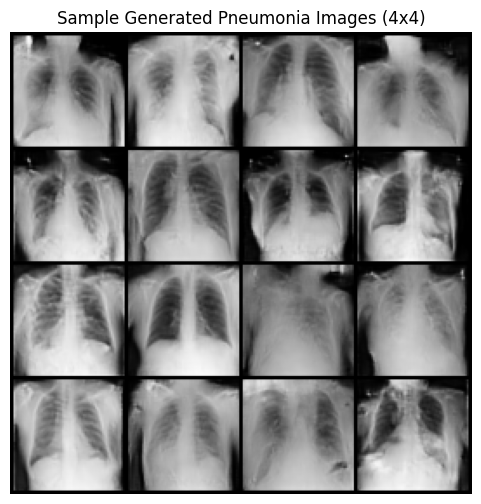

In [18]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

generator.load_state_dict(torch.load("best_vanilla_generator.pth", map_location=device))
generator.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    gen_labels = torch.ones(16, dtype=torch.long, device=device)  # Condition on pneumonia
    gen_imgs = generator(z)

# Convert images from [-1,1] to [0,1]
gen_imgs = (gen_imgs + 1) / 2
grid = make_grid(gen_imgs, nrow=4, padding=2, normalize=True)
np_grid = grid.cpu().numpy()
np_grid = np.transpose(np_grid, (1, 2, 0))

plt.figure(figsize=(6, 6))
plt.imshow(np_grid)
plt.title("Sample Generated Pneumonia Images (4x4)")
plt.axis("off")
plt.show()


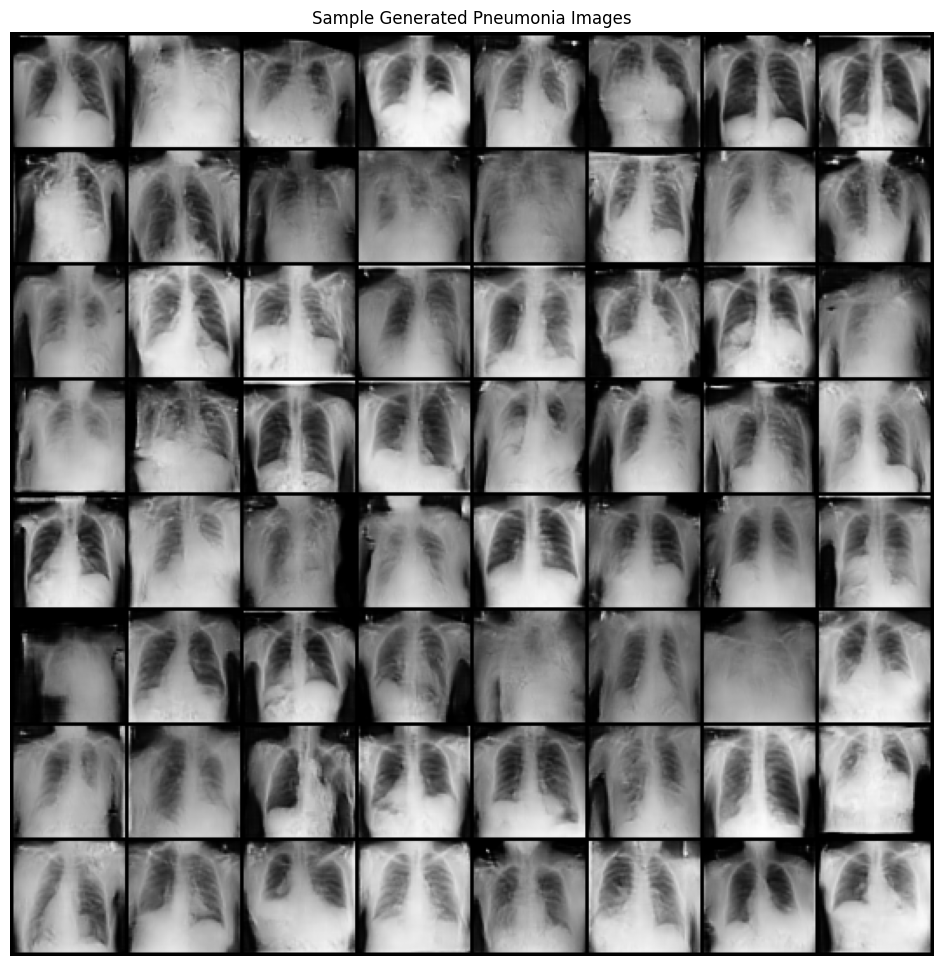

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

generator.load_state_dict(torch.load("best_vanilla_generator.pth", map_location=device))
generator.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    gen_labels = torch.ones(64, dtype=torch.long, device=device)  # Condition on pneumonia
    gen_imgs = generator(z)
    
# Convert images from [-1,1] to [0,1]
gen_imgs = (gen_imgs + 1) / 2
grid = make_grid(gen_imgs, nrow=8, padding=2, normalize=True)
np_grid = grid.cpu().numpy()
np_grid = np.transpose(np_grid, (1, 2, 0))

plt.figure(figsize=(12, 12))
plt.imshow(np_grid)
plt.title("Sample Generated Pneumonia Images")
plt.axis("off")
plt.show()